In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.text as mtext
from matplotlib.colors import TwoSlopeNorm
import textwrap
from core import med_log_odds_cutoff, bw_color_palette
import numpy as np
from tqdm import tqdm

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
def assign_hit_category(row, qcov=0.4):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    elif row['q_cov'] > qcov:
        return 'Remote defense homolog'
    elif row['foldseek_q_cov'] > qcov:
        return 'Structural defense homolog'
    else:
        return 'Predicted novel defense gene'

In [5]:
def select_domains(hhblits_df, prob_cutoff=50):
    # Other Domains
    out_list = []
    filt_df = hhblits_df[(hhblits_df['Prob'] > prob_cutoff)]
    for group, group_df in tqdm(filt_df.groupby('query'), 
                                position=0, total=filt_df['query'].nunique()):
        group_df = group_df.sort_values('Prob', ascending=False)
        while len(group_df):
            selected_row = group_df.head(1).squeeze()
            out_list.append(selected_row)
            group_df = group_df[(group_df['qend'] < selected_row['qstart']) |
                                (group_df['qstart'] > selected_row['qend'])]
    selected_domain_df = pd.concat(out_list, axis=1).T
    return selected_domain_df

In [6]:
search_df = pd.read_table('../data3/interim/ecoli3k_put_novel_rep_search.txt', 
                          names=["query", "target", "fident", "alnlen", "mismatch", "gapopen", "qstart", "qend", "tstart", "tend", "qcov", "tcov", "evalue", "bits", "alntmscore", "qtmscore", "ttmscore", "rmsd", "lddt", "prob"])
predictions = pd.read_parquet('../data3/interim/ecoli3k_predicted_defense.pq')
hhpred_results = pd.read_csv('../data3/interim/ecoli_3k_putative_novel_pfam_df_domains.csv')
blacklisted_domains = pd.read_csv('../data3/interim/df_blacklisted_domains.csv')
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', 
                           names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])

In [7]:
og_predictions = pd.read_parquet('../data3/processed/ecoli_3k_predictions.pq')

In [8]:
clusters = og_predictions[['product_accession', 'cluster_id']].drop_duplicates()

In [9]:
cluster_size = (clusters['cluster_id']
                .value_counts()
                .reset_index()
                .rename(columns={'count': 'cluster_size'}))

In [10]:
top_search_df = (search_df.sort_values('prob', ascending=False)
                 .groupby('query')
                 .head(1))

In [11]:
homolog_df = (top_search_df[top_search_df['prob'] > 0.6]
              .reset_index(drop=True))

In [12]:
merged_predictions = (predictions
                      .merge(homolog_df
                             .rename(columns={'query': 'product_accession',
                                              'target': 'foldseek_hit',
                                              'prob': 'foldseek_prob',
                                              'qcov': 'foldseek_q_cov'}), 
                             how='left', on='product_accession'))
merged_predictions['foldseek_q_cov'] = merged_predictions['foldseek_q_cov'].fillna(0)

In [13]:
merged_predictions['hit_category'] = merged_predictions.apply(assign_hit_category, axis=1)
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Remote defense homolog', 
                  'Structural defense homolog',
                  'Predicted novel defense gene']
merged_predictions['hit_category'] = pd.Categorical(merged_predictions['hit_category'], 
                                                    categories=hit_categories)

In [14]:
merged_predictions['hit_category'].value_counts()

hit_category
Predicted novel defense gene          1041
Defense homolog in new context        1037
Remote defense homolog                 717
Defense homolog in expected system     697
Structural defense homolog             168
Name: count, dtype: int64

In [15]:
((merged_predictions['hit_category'] == 'Predicted novel defense gene') & 
 (merged_predictions['q_cov'] == 0) & 
 (merged_predictions['foldseek_q_cov'] == 0)).sum()

656

In [16]:
genomes = og_predictions['assembly'].drop_duplicates()
len(genomes)

3000

In [17]:
n_boot = 10

In [18]:
sample_range = [int(x) for x in np.linspace(1, len(genomes), num=50)]
n_def_cluster_list = list()
for n in tqdm(sample_range):
    for boot in range(n_boot):
        sampled_genomes = set(genomes.sample(n=n, random_state=boot))
        sampled_clusters = set(og_predictions.loc[og_predictions['assembly'].isin(sampled_genomes), 'cluster_id'])
        sampled_def_df = merged_predictions[merged_predictions['cluster_id'].isin(sampled_clusters)]
        n_def_clusters = (sampled_def_df['hit_category']
                          .value_counts()
                          .reset_index())
        n_def_clusters['n_genomes'] = n
        n_def_cluster_list.append(n_def_clusters)
cat_n_def_cluster = pd.concat(n_def_cluster_list)

100%|██████████| 50/50 [10:26<00:00, 12.53s/it]


In [19]:
agg_n_def_cluster = (cat_n_def_cluster.groupby(['hit_category', 'n_genomes'])
                     .agg({'count': 'mean'})
                     .reset_index())

In [20]:
agg_n_def_cluster['hit_category'] = pd.Categorical(agg_n_def_cluster['hit_category'], 
                                                         categories=hit_categories)

In [21]:
color_palette = sns.color_palette(['#e69f00', '#56b4e9', '#009e73', '#0072b2','#f0e442'])

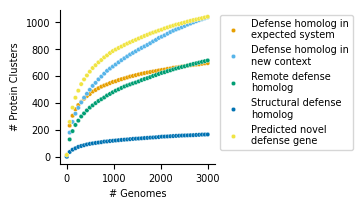

In [22]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_n_def_cluster, x='n_genomes', y='count', hue='hit_category',
              palette=color_palette, s=10)
sns.despine()
# Adjust legend
legend = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
handles, labels = legend.get_texts(), [text.get_text() for text in legend.get_texts()]
wrapped_labels = [textwrap.fill(label, 20) for label in labels]
for text, wrapped_label in zip(handles, wrapped_labels):
    text.set_text(wrapped_label)
# Other plot attributes
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')
plt.savefig('../figures/ecoli3k_predicted_category_per_genome.svg', dpi=300, bbox_inches='tight')

In [23]:
merged_predictions.to_parquet('../data3/interim/ecoli3k_predicted_defense_struct.pq', index=False)

In [27]:
novel_predictions = merged_predictions.query("hit_category == 'Predicted novel defense gene'")

In [28]:
len(novel_predictions)

1041

In [29]:
novel_predictions.to_parquet('../data3/interim/ecoli3k_novel_predicted_defense_struct.pq', index=False)

## Get new domains

In [30]:
pfam_hhpred_results = hhpred_results[hhpred_results['hit_name'].str.startswith('PF') & 
                                     hhpred_results['query'].isin(novel_predictions['product_accession'])]

In [32]:
select_pfam = select_domains(pfam_hhpred_results)

100%|██████████| 730/730 [00:00<00:00, 787.59it/s]


In [33]:
select_pfam['pfam_id'] = select_pfam['hit_name'].str.split('.', expand=True)[0]
select_pfam = select_pfam.merge(pfam_clans, how='inner', on='pfam_id')

In [34]:
filtered_pfam = select_pfam[~select_pfam['pfam_id'].isin(blacklisted_domains['pfam_id'].unique()) & 
                            ~select_pfam['clan_id'].isin(blacklisted_domains['clan_id'].dropna().unique())]

In [35]:
filtered_pfam['pfam_id'].nunique()

195

In [36]:
merged_pfam = (filtered_pfam.rename(columns={'query': 'product_accession'})
               .merge(merged_predictions, how='inner', on='product_accession', 
                      suffixes=('_Pfam', '_DF'))
               .merge(cluster_size, how='inner', on='cluster_id'))
merged_pfam['hhblits_rank_pfam'] = merged_pfam['Prob_Pfam'].rank(pct=True)
merged_pfam['pred_rank'] = merged_pfam['mean_log_odds'].rank(pct=True)
merged_pfam['cluster_rank'] = merged_pfam['cluster_size'].rank(pct=True)
merged_pfam['hhblits_rank_df'] = merged_pfam['q_cov'].rank(pct=True, ascending=False)
merged_pfam['foldseek_rank'] = merged_pfam['foldseek_q_cov'].rank(pct=True, ascending=False)
merged_pfam['mean_rank'] = merged_pfam[['hhblits_rank_pfam', 'pred_rank',
                                        'cluster_rank', 'hhblits_rank_df',
                                        'foldseek_rank']].mean(axis=1)

In [37]:
unique_merged_pfam = (merged_pfam.sort_values('mean_rank', ascending=False)
                      .groupby('pfam_id')
                      .head(1))

In [44]:
unique_merged_pfam

,Hit,Prob_Pfam,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,product_accession,...,rmsd,lddt,foldseek_prob,cluster_size,hhblits_rank_pfam,pred_rank,cluster_rank,hhblits_rank_df,foldseek_rank,mean_rank
282,PF19614.2 ; DUF6119 ; Family o,100.0,0.0,0.0,685.4,0.0,478.0,5-518,1-523 (523),WP_044067311.1,...,NaN,NaN,NaN,15,0.928760,0.905013,0.916887,0.638522,0.501319,0.778100
50,PF04245.16 ; NA37 ; 37-kD nucl,100.0,0.0,0.0,289.0,0.0,318.0,10-362,1-318 (318),WP_120130707.1,...,NaN,NaN,NaN,11,0.928760,0.891821,0.866755,0.638522,0.501319,0.765435
10,PF10987.11 ; DUF2806 ; Protein,100.0,0.0,0.0,265.9,0.0,201.0,61-266,1-221 (221),WP_000052343.1,...,NaN,NaN,NaN,7,0.928760,0.907652,0.773087,0.638522,0.501319,0.749868
165,PF13708.9 ; DUF4942 ; Domain o,100.0,0.0,0.0,280.7,0.0,179.0,84-265,1-212 (212),WP_001192736.1,...,NaN,NaN,NaN,867,0.928760,0.635884,0.997361,0.638522,0.501319,0.740369
216,PF16289.8 ; PIN_12 ; PIN domai,99.6,0.0,0.0,154.3,0.0,158.0,8-175,1-163 (163),WP_031619804.1,...,NaN,NaN,NaN,13,0.689974,0.977573,0.890501,0.638522,0.501319,0.739578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,PF01007.23 ; IRK ; Inward rect,97.3,0.0,0.0,67.8,0.0,61.0,307-371,81-141 (141),WP_000013735.1,...,NaN,NaN,NaN,1,0.432718,0.094987,0.154354,0.197889,0.501319,0.276253
145,PF07790.14 ; Pilin_N ; Archaea,67.5,0.28,0.00005,25.9,0.0,36.0,44-83,38-74 (77),WP_000651188.1,...,NaN,NaN,NaN,2,0.189974,0.105541,0.385224,0.155673,0.501319,0.267546
334,PF16765.8 ; Pim ; Pesticin imm,95.7,0.000053,0.0,52.3,0.0,67.0,257-335,20-88 (91),WP_096266450.1,...,NaN,NaN,NaN,1,0.403694,0.158311,0.154354,0.097625,0.501319,0.263061
230,PF03695.16 ; UPF0149 ; Unchara,91.6,0.0044,0.000001,43.7,0.0,65.0,41-116,14-83 (165),WP_016239971.1,...,NaN,NaN,NaN,1,0.345646,0.029024,0.154354,0.229551,0.501319,0.251979


In [45]:
unique_merged_pfam.to_csv('../data3/interim/ecoli_3k_putative_novel_pfam.csv', index=False)